In [1]:
import os

import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd

import geopandas as gpd
from shapely.geometry import Polygon

%matplotlib inline
from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
import mitequinox.parcels as pa

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.4031186.datarmor0/parcels-502090/libparcels_random_b32653e0-a8b8-4b06-86e2-91a7bc07728a.so


In [2]:
from dask.distributed import Client, LocalCluster

if True:
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    w = cluster.scale(jobs=2)
else:    
    cluster = LocalCluster()
client = Client(cluster)
client

Client Scheduler: tcp://10.148.0.33:33046 Dashboard: http://10.148.0.33:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
root_dir = '/home1/datawork/aponte/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['time'])
df = p.df['time']
df.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity
time,,,,,,,,,
2011-11-15,39000000,57.835732,-178.867081,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000001,58.429878,-178.871994,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000002,59.018066,-178.879623,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000003,59.600288,-178.890015,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000004,60.176525,-178.903275,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
t_start = df.index.min().compute()
t_end = df.index.max().compute()
delta_t = (t_end - t_start)/pd.Timedelta('1D') # in days

print(t_start, t_end, delta_t)

2011-11-15 00:00:00 2012-11-09 01:00:00 360.0416666666667


In [5]:
# geographical bins
dl = 1.
lon_bins = np.arange(-180.,180., dl)
lat_bins = np.arange(-90.,90., dl)

# temporal bins
#t_bins = pd.date_range(t_start, t_end, freq='1M')
t_bins = pd.date_range(t_start, t_end, freq='1MS') # starts at the beginning of each month
cut = lambda df, bins: pd.cut(df.index.to_series(), bins=bins)

In [6]:
df['lon'] = (df['lon']+180)%360 - 180
df['lon_cut'] = df['lon'].map_partitions(pd.cut, lon_bins)
df['lat_cut'] = df['lat'].map_partitions(pd.cut, lat_bins)
df['time_cut'] = df.map_partitions(cut, t_bins)

In [9]:
def degs2ms(df,V):
    if V=='meridional_velocity':
        return df[V] * 1000. * 1.852 * 60.
    if V=='zonal_velocity':
        return df[V] * 1000. * 1.852 * 60. * np.cos(df['lat'] * np.pi / 180)
    

In [10]:
df['zonal_velocity'] = degs2ms(df,'zonal_velocity')
df['meridional_velocity'] = degs2ms(df,'meridional_velocity')

In [11]:
df['velocity_amplitude'] = np.sqrt(df.zonal_velocity**2+df.meridional_velocity**2)

In [12]:
df = df.persist()

In [13]:
def add_geodata(df):

    df['lon'] = df.apply(lambda r: r.name[0].mid, axis=1)
    df['lat'] = df.apply(lambda r: r.name[1].mid, axis=1)

    def build_polygon(r):
        lon0, lon1 = r.name[0].left, r.name[0].right
        lat0, lat1 = r.name[1].left, r.name[1].right
        return Polygon([[lon0, lat0],[lon1, lat0], [lon1, lat1], [lon0, lat1]])

    df['Coordinates'] = df.apply(build_polygon, axis=1)
    df = gpd.GeoDataFrame(df, geometry='Coordinates', crs='EPSG:4326')
    df['area'] = df.to_crs(crs = 'epsg:3857').area /1e6 / 1e4 # 100km^2 units
    
    return df

In [19]:
mean_std = (df.groupby([df.lon_cut, df.lat_cut]).agg(['mean']).compute())

ValueError: Metadata inference failed in `_groupby_apply_funcs`.

You have supplied a custom function and Dask is unable to 
determine the type of output that that function returns. 

To resolve this please provide a meta= keyword.
The docstring of the Dask function you ran should have more information.

Original error is below:
------------------------
TypeError('Categorical cannot perform the operation sum')

Traceback:
---------
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/dask/dataframe/utils.py", line 172, in raise_on_meta_error
    yield
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/dask/dataframe/core.py", line 4911, in _emulate
    return func(*_extract_meta(args, True), **_extract_meta(kwargs, True))
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/dask/dataframe/groupby.py", line 881, in _groupby_apply_funcs
    r = func(grouped, **func_kwargs)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/dask/dataframe/groupby.py", line 918, in _apply_func_to_column
    return func(df_like[column])
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/dask/utils.py", line 881, in __call__
    return getattr(obj, self.method)(*args, **kwargs)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/pandas/core/groupby/groupby.py", line 1542, in sum
    numeric_only=numeric_only, min_count=min_count, alias="add", npfunc=np.sum
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/pandas/core/groupby/groupby.py", line 1017, in _agg_general
    result = self.aggregate(lambda x: npfunc(x, axis=self.axis))
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/pandas/core/groupby/generic.py", line 256, in aggregate
    func, *args, engine=engine, engine_kwargs=engine_kwargs, **kwargs
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/pandas/core/groupby/groupby.py", line 1094, in _python_agg_general
    return self._python_apply_general(f, self._selected_obj)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/pandas/core/groupby/groupby.py", line 892, in _python_apply_general
    keys, values, mutated = self.grouper.apply(f, data, self.axis)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/pandas/core/groupby/ops.py", line 213, in apply
    res = f(group)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/pandas/core/groupby/groupby.py", line 1062, in <lambda>
    f = lambda x: func(x, *args, **kwargs)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/pandas/core/groupby/groupby.py", line 1017, in <lambda>
    result = self.aggregate(lambda x: npfunc(x, axis=self.axis))
  File "<__array_function__ internals>", line 6, in sum
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/numpy/core/fromnumeric.py", line 2229, in sum
    initial=initial, where=where)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/numpy/core/fromnumeric.py", line 88, in _wrapreduction
    return reduction(axis=axis, out=out, **passkwargs)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/pandas/core/generic.py", line 11428, in stat_func
    min_count=min_count,
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/pandas/core/series.py", line 4239, in _reduce
    return delegate._reduce(name, skipna=skipna, **kwds)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/pandas/core/arrays/categorical.py", line 2082, in _reduce
    raise TypeError(f"Categorical cannot perform the operation {name}")


In [14]:
means = (df
         .groupby([df.lon_cut, df.lat_cut])
         .mean()
         .compute()
         #.to_frame()
        )



means = add_geodata(means)
#count['density'] = count['count']/count['area']

ds = (means
      .drop(columns=['Coordinates'])
      .set_index(['lon', 'lat'])
     .to_xarray()
    )

In [15]:
std = (df
         .groupby([df.lon_cut, df.lat_cut])
         .std()
         .compute()
         #.to_frame()
        )



std = add_geodata(std)

ds_std = (std
      .drop(columns=['Coordinates'])
      .set_index(['lon', 'lat'])
     .to_xarray()
    )

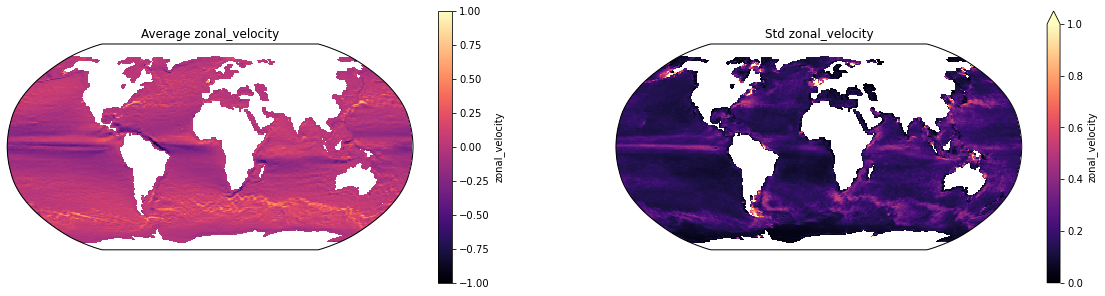

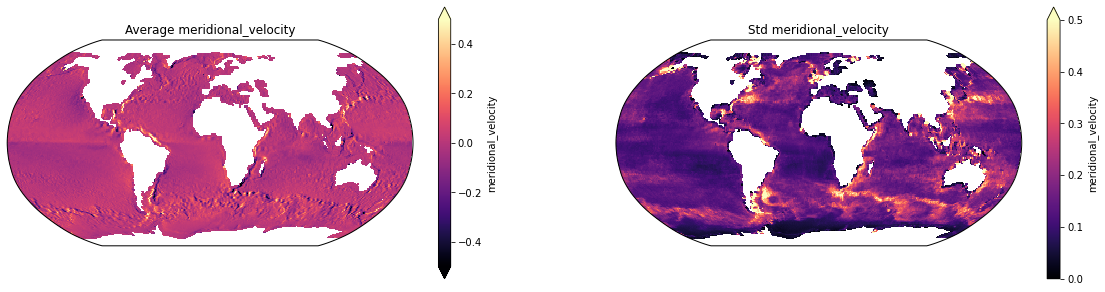

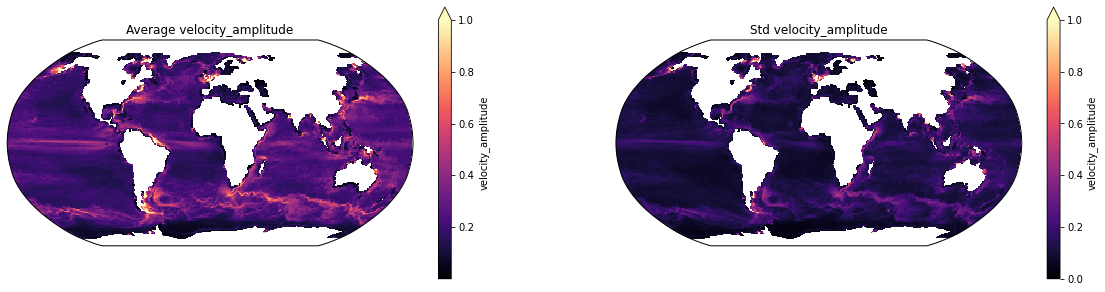

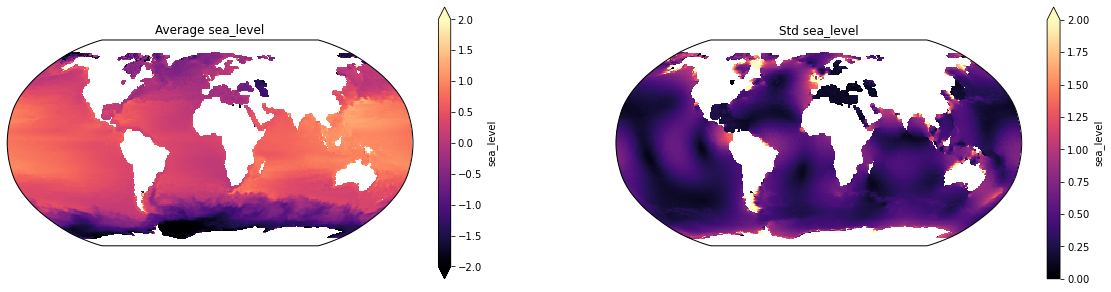

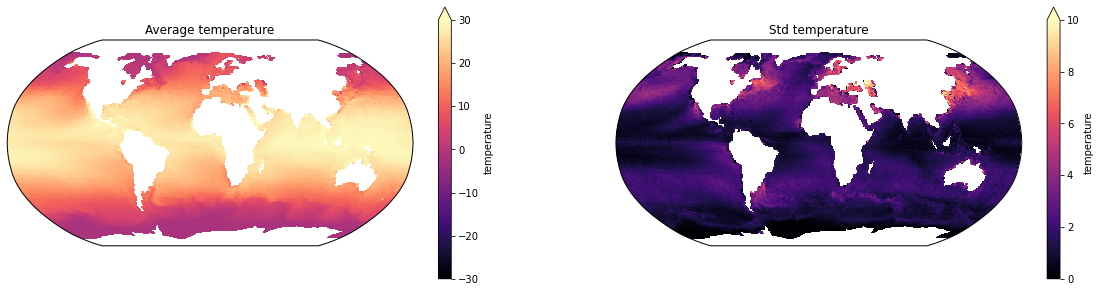

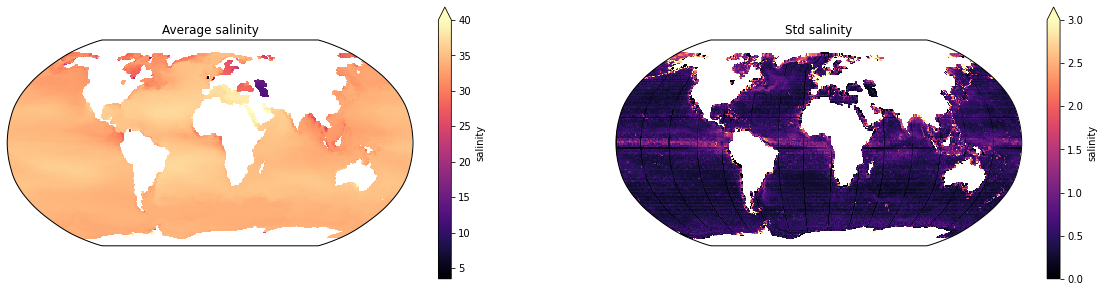

In [17]:
for V,vmax in zip(['zonal_velocity', 'meridional_velocity','velocity_amplitude','sea_level','temperature','salinity'],[[1,1],[0.5,0.5],[1,1],[2,2],[30,10],[40,3]]):
    figsize = (20,5)

    #crs = ccrs.Mollweide()
    crs = ccrs.Robinson()
    #crs = ccrs.EqualEarth()
    #crs = ccrs.Geodetic()

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(121, projection=crs)

    ds[V].plot(x='lon', 
                     y='lat',
                     vmax=vmax[0],
                     cmap='magma',
                     ax=ax,
                     transform=ccrs.PlateCarree(),
                    )
    plt.title('Average '+V)
    ax = fig.add_subplot(122, projection=crs)

    ds_std[V].plot(x='lon', 
                     y='lat',
                     vmax=vmax[1],
                     cmap='magma',
                     ax=ax,
                     transform=ccrs.PlateCarree(),
                    )
    plt.title('Std '+V)
    #ax.add_feature(cfeature.LAND, zorder=1)



In [20]:
ds = ds.drop(['z','trajectory'])
ds_var = ds_var.drop(['z','trajectory'])

In [21]:
ds

<xarray.Dataset>
Dimensions:              (lat: 179, lon: 359)
Coordinates:
  * lon                  (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5
  * lat                  (lat) float64 -89.5 -88.5 -87.5 ... 86.5 87.5 88.5
Data variables:
    zonal_velocity       (lon, lat) float64 nan nan nan nan ... nan nan nan nan
    meridional_velocity  (lon, lat) float64 nan nan nan nan ... nan nan nan nan
    sea_level            (lon, lat) float64 nan nan nan nan ... nan nan nan nan
    temperature          (lon, lat) float64 nan nan nan nan ... nan nan nan nan
    salinity             (lon, lat) float64 nan nan nan nan ... nan nan nan nan
    velocity_amplitude   (lon, lat) float64 nan nan nan nan ... nan nan nan nan
    area                 (lon, lat) float64 nan 49.22 28.8 ... 20.44 28.8 49.22

In [ ]:
p.store_diagnostic("mean_diags", ds, directory = ,overwrite=True)

In [19]:
p.store_diagnostic?

Signature:
p.store_diagnostic(
    name,
    data,
    overwrite=False,
    directory='diagnostics/',
    **kwargs,
)
Docstring:
Write diagnostics to disk

Parameters
----------
name: str
    Name of a diagnostics to store on disk
data: dd.DataFrame (other should be implemented)
    Data to be stored
overwrite: boolean, optional
    Overwrite an existing diagnostic. Default is False
directory: str, optional
    Directory where diagnostics will be stored (absolute or relative to output directory).
    Default is 'diagnostics/'
**kwargs:
    Any keyword arguments that will be passed to the file writer
File:      ~/miniconda3/envs/croco/lib/python3.7/site-packages/mitequinox/parcels.py
Type:      method


In [18]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
